# Chainerによる畳み込みニューラルネットワーク

## 本チュートリアルではchainerを利用してニューラルネットワークの実装を確認，学習および評価を行います．　環境としてはGoogle が提供する Google Colaboratory上でおこないます． GPU上で処理を行うため，colaboratoryの[ランタイム]->[ランタイムのタイプを変更]からハードウェアアクセラレータをGPUにしてください．

Chainerでニューラルネットワークを学習するために必要なモジュールや関数をインポートします．

In [1]:
import numpy as np
import chainer
from chainer import cuda, optimizers
from chainer import Chain, Variable
import chainer.functions as F
import chainer.links as L

今回はGPUを利用します．GPUが利用できるか確認します．

In [2]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: False
cuDNN availablility: False


次に学習データを読み込みます．MNISTデータセットはチュートリアルでよく利用されるデータセットであり，chainerではMNISTデータセットを取得し，学習するためのフォーマットに変換してくれます．データセットには学習用とテスト用のデータに別れており，それぞれtrain_dataset, test_datasetとします．また，それらには画像データと教師ラベルがあり，それらをtrain_xとtrain_y，test_xとtest_yとします．

In [3]:
train_dataset, test_dataset = chainer.datasets.get_mnist(ndim=3)
train_x, train_y = train_dataset._datasets
test_x, test_y = test_dataset._datasets

学習データのサイズを確認します．学習データサイズは6万枚，１つのデータのサイズは1x28x28の画像のような形式となっています．

In [4]:
print(train_x.shape, train_y.shape)

(60000, 1, 28, 28) (60000,)


MNISTデータセットに含まれる画像を表示してみます．ここでは，matplotlibで複数の画像を表示させるプログラムを利用します．

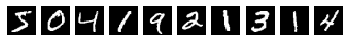

In [6]:
import cv2
import matplotlib.pyplot as plt
import os.path

cols =10

def clearLabel(_ax):
    _ax.tick_params(labelbottom=False, bottom=False)
    _ax.tick_params(labelleft=False, left=False)
    _ax.set_xticklabels([]) 
    _ax.axis('off')
    return _ax

def readImage(idx):
    bimg = train_x[idx].copy()
    label = train_y[idx]
    bimg = bimg.reshape(28,28)
    return bimg

fig = plt.figure()

for c in range(cols):
    ax1 = fig.add_subplot(1, cols, c+1)
    clearLabel(ax1)
    show_img1 = readImage(c)
    plt.gray()
    plt.imshow(show_img1)

畳み込みニューラルネットワークを定義します．ここでは，畳み込み層２層，全結合層３層から構成されるネットワークとします．１層目の畳み込み層は入力チャンネル数が１，出力する特徴マップ数が16，畳み込むフィルタサイズが3x3です．２層目の畳み込み層は入力チャネル数が16．出力する特徴マップ数が32，畳み込むフィルタサイズは同じく3x3です．１つ目の全結合層は入力ユニット数は不定とし，出力は1024としています．次の全結合層入力，出力共に1024，出力層は入力が1024，出力が10です．これらの各層の構成を\__init|\__関数で定義します．
次に，\__call\__関数では，定義した層を接続して処理するように記述します．\__call\__関数の引数xは入力データです．それを\__init\__関数で定義したconv1に与え，その出力を活性化関数であるrelu関数に与えます．そして，その出力をmax_pooling_2dに与えて，プーリング処理結果をhとして出力します．hはconv2に与えられて畳み込み処理とプーリング処理を行います．そして，出力hをl1に与えて全結合層の処理を行います．最終的にl3の全結合層の処理を行った出力hを戻り値としています．


In [7]:
class CNN(Chain):
    def __init__(self):
        super(CNN, self).__init__(
            conv1 = L.Convolution2D(1, 16, 3), 
            conv2 = L.Convolution2D(16, 32, 3), 
            l1 = L.Linear(None, 1024),
            l2 = L.Linear(1024, 1024),
            l3 = L.Linear(1024, 10)
        )
    def __call__(self, x):
        h = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h = F.max_pooling_2d(F.relu(self.conv2(h)), 2)
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        return h

畳み込みネットワークモデルを定義します．学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します．また，学習率を0.01，モーメンタムを0.9として引数に与えます．そして，最適化方法のsetup関数にネットワークモデルを与えます．ここでは，GPUで学習を行うために，modelをGPUに送るto_gpu関数を利用しています．また，GPUに対応した行列演算モジュールのcupyを呼び出しています．

In [8]:
gpu_id = 0 
xp = cuda.cupy
model = CNN()
model.to_gpu(gpu_id)

optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)

学習およびテストデータをcupyの形式に変換します．cupyはnumpyと互換性があります．

In [ ]:
train_x = xp.array(train_x, dtype=xp.float32)
train_y = xp.array(train_y, dtype = xp.int32)
test_x = xp.array(test_x, dtype=xp.float32)
test_y = xp.array(test_y, dtype = xp.int32)

１回の誤差を算出するデータ数（ミニバッチサイズ）を100，学習エポック数を100とします．MNISTの学習データサイズを取得し，１エポック内における更新回数を求めます．学習データは毎エポックでランダムに利用するため，numpyのpermutationという関数を利用します．各更新において，学習用データと教師データをそれぞれxとtとし，to_gpu関数でGPUに転送します．学習モデルにxを与えて各クラスの確率yを取得します．各クラスの確率yと教師ラベルtとの誤差をsoftmax coross entropy誤差関数で算出します．また，認識精度も算出します．そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

In [10]:
batch_size = 100
epoch_num = 10
train_data_num = train_x.shape[0]
iter_one_epoch = int(train_x.shape[0]/batch_size)
for epoch in range(epoch_num):
    sum_loss = 0
    sum_accuracy = 0
    perm = xp.random.permutation(train_data_num)
    for i in range(0, train_data_num, batch_size):
        x = Variable(cuda.to_gpu(train_x[perm[i:i+batch_size]]))
        t = Variable(cuda.to_gpu(train_y[perm[i:i+batch_size]]))
        y = model(x)        
        model.zerograds()
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        loss.backward()
        optimizer.update()
        sum_loss += loss.data*batch_size
        sum_accuracy += acc.data*batch_size
    print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch+1,
                                                               sum_loss/train_data_num,
                                                               sum_accuracy/train_data_num))

epoch: 1, mean loss: 0.23071776, mean accuracy: 0.9285333
epoch: 2, mean loss: 0.066432394, mean accuracy: 0.9791667
epoch: 3, mean loss: 0.04470107, mean accuracy: 0.9859667
epoch: 4, mean loss: 0.034174807, mean accuracy: 0.9892667
epoch: 5, mean loss: 0.025850417, mean accuracy: 0.9917833
epoch: 6, mean loss: 0.019931931, mean accuracy: 0.9935833
epoch: 7, mean loss: 0.015775127, mean accuracy: 0.9950167
epoch: 8, mean loss: 0.01342642, mean accuracy: 0.9957167
epoch: 9, mean loss: 0.00969821, mean accuracy: 0.9971333
epoch: 10, mean loss: 0.0072579943, mean accuracy: 0.99791664


学習できたネットワークモデルを利用して評価を行います．

In [11]:
cnt = 0
test_data_num = test_x.shape[0]
for i in range(test_data_num):
    x = Variable(cuda.to_gpu(test_x[i].reshape(1,1,28,28)))
    t = test_y[i]
    y = model(x)
    y = np.argmax(y.data[0])
    if t == y:
        cnt += 1
        
print("test accuracy: {}".format(cnt/test_data_num))

test accuracy: 0.9923


## 課題　
### 以下の課題に取り組みましょう

1  ネットワーク構造を変えて実験しましょう． 

   まず，1層目の畳み込み層のフィルタ数を32にしましょう．また，2層目の畳み込み層のフィルタ数を64にしましょう．
   
   次に，中間層のユニット数を2048にしましょう．

2  最適化の方法をAdamに変えて実験しましょう．


3  エポック数やミニバッチサイズを変えて実験しましょう．

  まず，ミニバッチサイズを128にしましょう．
  
  次に，エポック数を50にしましょう．

4  GPUの有無による速度の差を比較しましょう


##別のコードの書き方

前回のニューラルネットワークと同様にTrainerを利用したプログラムを作成します．

In [ ]:
import numpy as np
import chainer
from chainer import cuda, optimizers
from chainer import Chain, Variable
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

batch_size = 100
epoch_num = 10

n_units = 50
out_units = 10

model = L.Classifier(CNN())
model.to_gpu() 
optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)  
  
train_dataset, test_dataset = chainer.datasets.get_mnist(ndim =3)

train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
test_iter = chainer.iterators.SerialIterator(test_dataset, batch_size,    repeat=False, shuffle=False)

updater = training.updaters.StandardUpdater( train_iter, optimizer, device=0)
trainer = training.Trainer(updater, (epoch_num, 'epoch'), out='result')

trainer.extend(extensions.Evaluator(test_iter, model, device=0))

trainer.extend(extensions.dump_graph('main/loss'))

trainer.extend(extensions.LogReport())

trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],  'epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

trainer.run()